In [29]:
from collections import defaultdict
from functools import reduce
from itertools import chain, cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import smartsheet

from portfolio import CashFlow, debug_row, PortfolioSheetRow
from utils import colorscale, SmartsheetRow

# Portfolio Cash Flow Analysis

In [30]:
# Define a quartely time schema
years_in_model = 3
quarters = list(range(1, years_in_model * 4 + 1))  # list bc we don't want this to be a generator
quarters_index = list(range(years_in_model * 4))
quarter_labels = ['Q' + str(q) for q in quarters]

# smartsheet
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

# debug_row(38, sheet)

In [31]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 20
SHEET_ROW_END = 70

def sheet_row_to_cf(row):
    return CashFlow(
        delay_qtrs = row.delay_qtrs,
        discounted = True,
        discount_rate = row.discount_rate,
        max_amt = row.max_amt,
        scale_up_qtrs = row.scale_up_qtrs,
        function = row.function,
        name = row.name,
        is_cost = row.is_cost
    )

# iterate through smartsheet and build project map
project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue

    row = PortfolioSheetRow(sheet_row.to_dict())
    if row.project_code and row.include_in_model:
        project_map[row.project_code].append(sheet_row_to_cf(row))

# Build DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        rows.append([project_id, True, cash_flow.name] + cash_flow.discounted_qtr)  # Discounted
        rows.append([project_id, False, cash_flow.name] + cash_flow.non_discounted_qtr)  # Undiscounted
        
df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
df.groupby(['project', 'discounted']).sum(numeric_only=True).sum(numeric_only=True, axis=1).reset_index(name='NPV')

,project,discounted,NPV
0,BP,False,-4.678182
1,BP,True,-4.746166
2,FS,False,13.426765
3,FS,True,7.301263
4,PV,False,12.386509
5,PV,True,3.458543


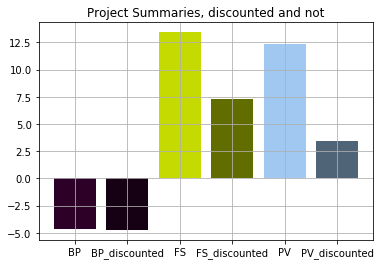

In [32]:
def gen_label(row):
    postfix = '_discounted' if row['discounted'] else ''
    return row['project'] + postfix

table = df.groupby(['project', 'discounted'])\
          .sum(numeric_only=True)\
          .sum(numeric_only=True, axis=1)\
          .reset_index(name='NPV')

table['label'] = table.apply(gen_label, axis=1)
table


# This is way overly complex, but was fun to write
colors = ["#2D0028", "#C5DA00", "#A0C8F0", "#9BA08C"]
colors_cycled = list(islice(
    cycle(colors),     # generator of infinitely repeated colors
    0,                 # start at the beginning
    len(project_map)), # we're going to zip later & 2x the proj num is # of bars
) 
darkened_colors = map(lambda color: colorscale(color, .5), colors_cycled)
bar_colors = list(chain.from_iterable(zip(colors_cycled, darkened_colors)))

# TODO: Add colors to bars based on project code beign in the x-axis label
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(table['label'], table['NPV'], color=bar_colors)
ax.set_title('Project Summaries, discounted and not')
ax.grid(True)

In [33]:
def display_dataframe(df, title):
    display(HTML(f'<div><h3>{title}</h3></div>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

    
for project_id in df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = df[df['project'] == project_id].set_index('name')
    display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,-0.3125,-0.304878,-0.297442,-0.290187,-0.283110,-0.276204,-0.269468,-0.262895,-0.256483,-0.250228,-0.244125,-0.238170
Pipeline FS Product Credits,-0.1800,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Pipeline FS - Stockton,0.0000,0.000000,0.000000,0.000000,0.122942,0.111766,0.101605,0.092368,0.083971,0.076338,0.069398,0.063089
Pipeline FS - Magic Valley,0.0000,0.000000,0.136106,0.118353,0.102916,0.089492,0.077819,0.067669,0.058842,0.051167,0.044493,0.038690
Projected Whitespace Wins,0.0000,0.000000,0.000000,0.129576,0.244355,0.438631,0.724998,1.066022,1.372924,1.572964,1.659398,1.666336
Projected Margin Accretion,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012536,0.023641,0.042437,0.070143,0.103137,0.132830
Total,-0.4925,-0.304878,-0.161336,-0.042259,0.187103,0.363684,0.647491,0.986805,1.301692,1.520385,1.632302,1.662775


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,-0.3125,-0.3125,-0.3125,-0.3125,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500
Pipeline FS Product Credits,-0.1800,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline FS - Stockton,0.0000,0.0000,0.0000,0.0000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Magic Valley,0.0000,0.0000,0.1800,0.1800,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Projected Whitespace Wins,0.0000,0.0000,0.0000,0.1500,0.297015,0.559816,0.971566,1.500000,2.028434,2.440184,2.702985,2.850000
Projected Margin Accretion,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.016800,0.033266,0.062699,0.108815,0.168000,0.227185
Total,-0.4925,-0.3125,-0.1325,0.0175,0.344515,0.607316,1.035866,1.580766,2.138633,2.596499,2.918485,3.124685


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,-0.000000,-0.048780,-0.095181,-0.139290,-0.181190,-0.220964,-0.258689,-0.294443,-0.328299,-0.360328,-0.390599,-0.419180
Internal Headcount,-0.593182,-0.578714,-0.564599,-0.550828,-0.537393,-0.524286,-0.511499,-0.499023,-0.486852,-0.474978,-0.463393,-0.452090
Revenue Defense - Showme,0.200000,0.192771,0.185803,0.179088,0.172615,0.166376,0.160362,0.154566,0.148979,0.143594,0.138404,0.133402
United Ethanol Whitespace Win,0.120000,0.115663,0.111482,0.107453,0.103569,0.099825,0.096217,0.092739,0.089387,0.086157,0.083042,0.080041
Guardian - Hankinson Defense,0.000000,0.000000,0.000000,0.000000,0.000000,0.147702,0.139013,0.130836,0.123140,0.115896,0.109079,0.102662
Valero - Net new,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033932
Madeira - Fleet Trials,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057948,0.054539,0.051331
Total,-0.273182,-0.319061,-0.362495,-0.403578,-0.442400,-0.331347,-0.374595,-0.415325,-0.453644,-0.431710,-0.468927,-0.469902


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,-0.000000,-0.050000,-0.100000,-0.150000,-0.200000,-0.250000,-0.300000,-0.350000,-0.400000,-0.450000,-0.500000,-0.550000
Internal Headcount,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182
Revenue Defense - Showme,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
United Ethanol Whitespace Win,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000
Guardian - Hankinson Defense,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
Valero - Net new,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
Madeira - Fleet Trials,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000
Total,-0.273182,-0.323182,-0.373182,-0.423182,-0.473182,-0.323182,-0.373182,-0.423182,-0.473182,-0.423182,-0.473182,-0.323182


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-0.444886,-0.434035,-0.423449,-0.413121,-0.403045,-0.393215,-0.383624,-0.374267,-0.365139,-0.356233,-0.347545,-0.339068
Benefits - Contracted GPRE,0.375000,0.352941,0.332180,0.312640,0.294249,0.276941,0.260650,0.245318,0.230887,0.217306,0.204523,0.192492
Benefits - Potential GPRE,0.000000,0.000000,0.000000,0.158025,0.222410,0.307521,0.414211,0.537858,0.665971,0.779489,0.859559,0.896002
Total,-0.069886,-0.081094,-0.091269,0.057543,0.113614,0.191246,0.291237,0.408909,0.531719,0.640561,0.716537,0.749427


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886
Benefits - Contracted GPRE,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
Benefits - Potential GPRE,0.000000,0.000000,0.000000,0.225000,0.356258,0.554162,0.839725,1.226692,1.708737,2.250000,2.791263,3.273308
Total,-0.069886,-0.069886,-0.069886,0.155114,0.286372,0.484276,0.769838,1.156806,1.638850,2.180114,2.721377,3.203421


In [41]:
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
            
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]
        
        def get_max(flows):
            values = reduce(list.__add__, [list(map(lambda v: abs(v), flow.qtr)) for flow in flows])
            maximum = max(values)
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            rows = len(self.cash_flows) // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)  # or get_min_max
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                # TODO: should pull from "tot_qtrs" in some way
#                 linestyle_discounted = '-' if cf.discounted else '--'
#                 linestyle_non_discounted = '--' if cf.discounted else '-'
                ax.plot(range(12), cf.discounted_qtr, color='r', label='discounted')
                ax.plot(range(12), cf.non_discounted_qtr, label='non-discounted')
                ax.legend()
                
            plt.show(fig)

In [42]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id}</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))

,delay_qtrs,discount_rate,function,is_cost,max_amt,scale_up_qtrs,tot_qtrs
name,,,,,,,
Internal Headcount,0.0,0.0250,step,True,0.444886,2.0,12
Benefits - Contracted GPRE,0.0,0.0625,step,False,0.375000,2.0,12
Benefits - Potential GPRE,3.0,0.1250,sigmoid,False,4.500000,12.0,12


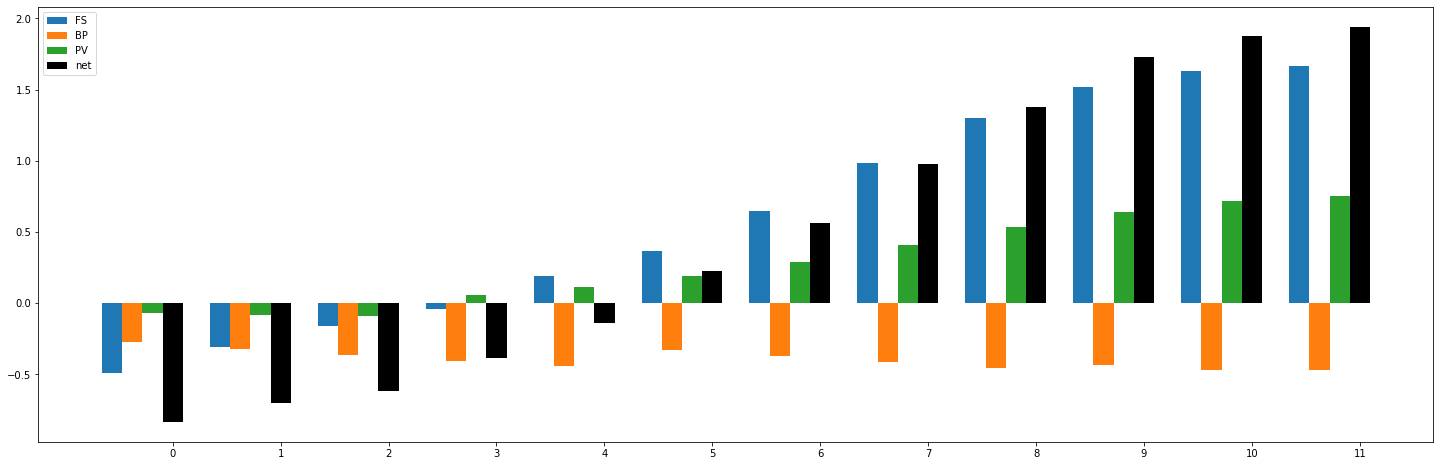

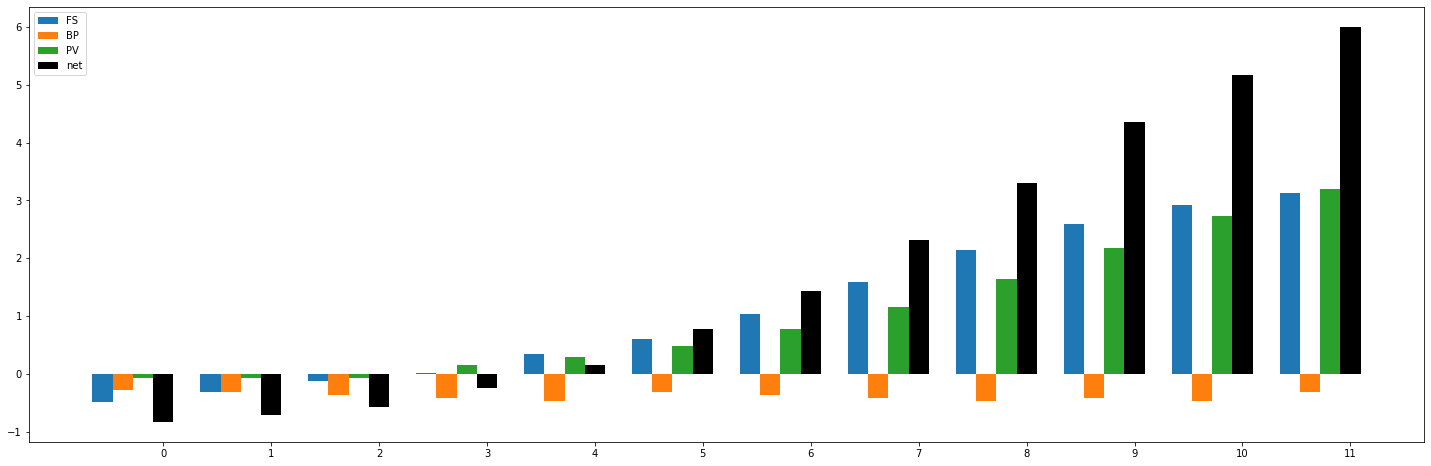

In [53]:
graph_out = widgets.Output()

def combine_flows(flows, is_discounted):
    if is_discounted:
        qtr_values = map(lambda cf: cf.discounted_qtr, flows)
    else:
        qtr_values = map(lambda cf: cf.non_discounted_qtr, flows)
    aggregated_values = [sum(values) for values in zip(*qtr_values)]
    return aggregated_values

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary(is_discounted):
    projects_values = map(lambda p: combine_flows(p.cash_flows, is_discounted), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (25, 8)
    plt.figure(figsize=figsize)
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(xseries, combine_flows(project.cash_flows, is_discounted), width=bar_width)
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(net_xseries, projects_net, color='black', width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:
        display(HTML('<h2>Discounted</h2>'))
        plot_projects_summary(is_discounted=True)
        
        display(HTML('<h2>Undiscounted</h2>'))
        plot_projects_summary(is_discounted=False)

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [0]:
df.sort_values(by=['discounted', 'project'], inplace=True)

In [0]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [0]:
# This entire cell contains all of the code needed
# to build the excel sheet to be downloaded

def record_project(project, sheet, start_row, start_column=0):
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(project.to_df(), 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    for index, row in project.to_df().iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./demo.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

In [0]:
%%html
<style>
.dwnld {
    border: 1px solid black;
    border-radius: 4px;
    padding: 5px;
    text-decoration: none !important;
}
</style>
<a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>